# Body segmentation test based in dense classification of the depth images to recognize the body parts

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
from PIL import Image

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
path = "/content/drive/MyDrive/DOCTORADO/TESIS/code/"

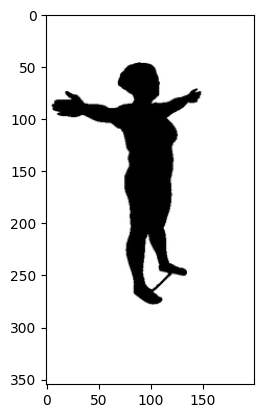

In [4]:
img = Image.open(path + 'masks/R46-252-mask.png')

# resize
basewidth = 200
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
resize_im = img.resize((basewidth, hsize), Image.ANTIALIAS)

# img to array
im = np.asarray(resize_im)

plt.imshow(im)

## mask info

In [5]:
# color data
alpha = im[:, :, 3]
cdata = im[:, :, :3]
cdata = cv2.cvtColor(cdata, cv2.COLOR_BGR2GRAY)

# margin
margin_1 = np.sum(alpha, axis=0)
margin_2 = np.sum(alpha, axis=1)

# margin mask
top = np.nonzero(margin_2)[0][0]
bottom = np.nonzero(margin_2)[0][-1]
left = np.nonzero(margin_1)[0][0]
right = np.nonzero(margin_1)[0][-1]

print("top", top)
print("bottom", bottom)
print("left", left)
print("right", right)

top 44
bottom 280
left 3
right 150


## scaler

In [6]:
# mask size (only siluette)
width = right - left
height = bottom - top
print("width", width)
print("height", height)

alpha = alpha[top:bottom, left:right]
cdata = cdata[top:bottom, left:right]

# scaler
target_window = 190
margin = 30

if height > width:
	scaler = (target_window, int(float(width * height)/target_window))
else:
	scaler = (int(float(width * height)/target_window), target_window)

print("scaler", scaler)

# depth image
depth_image = cv2.resize(cdata, scaler)
depth_mask = cv2.resize(alpha, scaler) == 255
average_depth = np.mean(depth_image[depth_mask])
depth_image[depth_mask] = np.uint8(np.int64(depth_image[depth_mask])) + np.int64(55 - average_depth)
depth_image[~depth_mask] = 255
depth_image = depth_image.astype(float)/255
# new height, width
height, width = depth_image.shape[0], depth_image.shape[1]

# final_depth_image
final_depth_image = np.ones((target_window + 2 * margin, target_window + 2 * margin), dtype=float)
final_depth_mask = np.zeros((target_window + 2 * margin, target_window + 2 * margin), dtype=bool)

# loc x, y
loc_x = int(np.floor((target_window + 2 * margin - width)/2) + 1)
loc_y = int(np.floor((target_window + 2 * margin - height)/2) + 1)

print("loc_x ", loc_x)
print("loc_y ", loc_y)

# final_depth_image
final_depth_image[loc_y: (loc_y + height), loc_x: (loc_x + width)] = depth_image
final_depth_mask[loc_y: (loc_y + height) , loc_x: (loc_x + width)] = depth_mask * 255

final_depth_image = np.float32(final_depth_image)

print("final_depth_image shape ", final_depth_image.shape)
final_depth_image

width 147
height 236
scaler (190, 182)
loc_x  31
loc_y  35
final_depth_image shape  (250, 250)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

### net model

In [7]:
net = cv2.dnn.readNetFromCaffe(path + "caffe_models/deploy.prototxt", path + "caffe_models/hardpose_69k.caffemodel")
blob = cv2.dnn.blobFromImage(final_depth_image, 1, (250, 250), (), True, False)
net.setInput(blob)
out = net.forward()

out

array([[[[0.03280518, 0.03269785, 0.03231836, ..., 0.03304716,
          0.0329381 , 0.03282369],
         [0.0326749 , 0.03246872, 0.03220016, ..., 0.03310845,
          0.03293565, 0.03309187],
         [0.03268528, 0.03237331, 0.03205069, ..., 0.0330192 ,
          0.03312834, 0.03305831],
         ...,
         [0.03194043, 0.03166587, 0.03150425, ..., 0.03228032,
          0.03246664, 0.03251262],
         [0.03184456, 0.03172294, 0.03154095, ..., 0.03222943,
          0.03230582, 0.03245379],
         [0.03182033, 0.03166842, 0.03157341, ..., 0.0320412 ,
          0.03227144, 0.03232733]],

        [[0.03487812, 0.03494771, 0.03453548, ..., 0.03532325,
          0.03569898, 0.03601362],
         [0.03493974, 0.03481807, 0.03438474, ..., 0.0351603 ,
          0.03579761, 0.03597433],
         [0.03477981, 0.0348171 , 0.03448277, ..., 0.03514465,
          0.03558773, 0.03593604],
         ...,
         [0.03524337, 0.03503212, 0.03483717, ..., 0.03507973,
          0.03524209, 0.0

In [8]:
classes =  np.argmax(out, axis=1)
classes = np.reshape(classes, (250, 250))
classes[~final_depth_mask] = 0

classes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

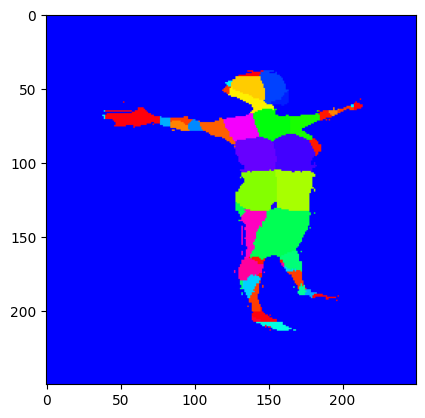

In [26]:
x,y = np.nonzero(classes)
classes = np.uint8(classes)
classes = classes * 5
img_seg = cv2.applyColorMap(classes, cv2.COLORMAP_HSV)

plt.imshow(img_seg)

In [27]:
img_seg

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

(375, 666)


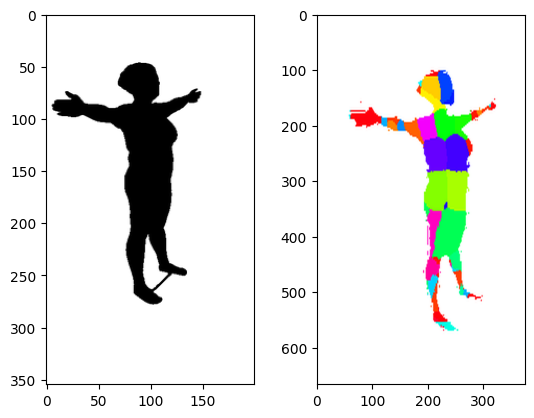

In [28]:
new_img_seg = Image.fromarray(np.uint8(img_seg)).convert('RGB')

bg = (0,0,255)
white = (255,255,255)

new_white = []

for color in new_img_seg.getdata():
    #print(color)
    if color == bg:
        new_white.append(white)
    else:
        new_white.append(color)

new_image = Image.new(new_img_seg.mode, new_img_seg.size)
new_image.putdata(new_white)

# resize
w, h = img.size
resize_new_im = new_image.resize((w, h), Image.ANTIALIAS)
print(resize_new_im.size)

# figure
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(im)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(resize_new_im)

In [29]:
resize_new_im.save(path + 'segmented/R46-252-seg.png')